### Credit
The exercise is based on material by Henrik Pedersen for the course _Deep Learning for Visual Recognition_.
https://kursuskatalog.au.dk/da/course/93556/Deep-Learning-for-Visual-Recognition


---



Ecercise# Lab 4
In this exercise, you will explore tools that will help you train your own neural networks.

## 1. Download the CIFAR 10 dataset and set up dataloaders
We will be using the CIFAR 10 dataset.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

mean = 0.5
std = 0.5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean, mean, mean), (std, std, std))])

# Batch size
bs = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2,drop_last=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Display some stats

num_train 49984
num_test 9984
images.shape torch.Size([64, 3, 32, 32])


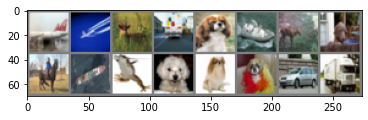

plane plane  deer truck   dog  ship  deer   dog horse  ship  frog   dog   dog   dog   car truck


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    npimg = img.numpy() / 2 + 0.5 # Un-normalize
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Number of samples
num_train = bs * len(trainloader)
num_test = bs * len(testloader)
print('num_train',num_train)
print('num_test',num_test)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('images.shape',images.shape)

# show 16 images and print labels
imshow(torchvision.utils.make_grid(images[0:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

## Setting up device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:',device)

Device: cpu


## 2.  Setting up your CNN
### **You can skip 2.1, 2.2, 2.4, and 2.6, if you feel comfortable with PyTorch and these layer types.**

Here, we will set up our own CNN. For this purpose we will need the following layer types:

- [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
- [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d)
- [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
- [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout)
- [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear])

as well as the reshape operation (called `view` in PyTorch):

- [view](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view)

See complete overview of the basic building block for graphs [here](https://pytorch.org/docs/stable/nn.html).

In [ ]:
# First import what we need
import torch.nn as nn
import torch.nn.functional as F

### 2.1 Conv2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

In [ ]:
# Print shape of input
print('Input dimensions are (batch_size, channels, height, width)')
print('images.shape',images.shape)

# Perform convolution
conv = nn.Conv2d(3, 6, 5)
x = conv(images)

# Print shape of output
print('x.shape',x.shape)

# Print parameter shapes
for name, param in conv.named_parameters(): print('parameter',name,param.shape)

Input dimensions are (batch_size, channels, height, width)
images.shape torch.Size([64, 3, 32, 32])
x.shape torch.Size([64, 6, 28, 28])
parameter weight torch.Size([6, 3, 5, 5])
parameter bias torch.Size([6])


#### 2.1.1 Questions
1. What do each of the parameters (3, 6, 5) mean?

1- (in_channels, out_channels, kernel_size) = (3, 6, 5), where in_channels is the number of channels of the input (3 here because input is a color image), out_channels is the number of feature maps that will be generated, and kernel_size is the filter size.

2. Recall the formula to calculate the output size of a convolution:

2- Yes. We have N = input_size = 32, W = kernel_size = 5, stride = 1 (default), so theoretically output_size = (32-5)/1 + 1 = 28, which matches the shape of x.

 `output_size = (input_size - kernel_size) / stride + 1`

 Is this formula satisfied in the above example?

3. How could you make the output (x) have the same width and height as the input (images)? (Think "padding"...)

3- Conv2d has a padding option. By setting padding = 2, the output gets the same width/height as the input (see code below). The formula for calculating the right padding size is (see slides from lecture 5): padding = (W-1)/2 = (5-1)/4 = 2.

4. If the convolution operation performed above was a layer in a CNN, what would the number of parameters of that layer be?

4- For the filter weights the number of parameters is out_channels * in_channels * kernel_size^2 = 6 * 3 * 5 * 5 = 450. In addition there is one bias parameters for each output, totalling 450 + 6 = 456 parameters.

In [ ]:
# Code for question 2: Padding
conv = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)
x = conv(images)

# Width and height are the same
print('x.shape',x.shape)
print('images.shape',images.shape)

# Print parameter shapes
for name, param in conv.named_parameters(): print('parameter',name,param.shape)

x.shape torch.Size([64, 6, 32, 32])
images.shape torch.Size([64, 3, 32, 32])
parameter weight torch.Size([6, 3, 5, 5])
parameter bias torch.Size([6])


### 2.2 MaxPool2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d

In [ ]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)

# Perform max pool
pool = nn.MaxPool2d(2, 2)
y = pool(x)
print('y.shape',y.shape)

# Print some elements
print('x[0,0,0:4,0:4]:\n',x[0,0,0:4,0:4])
print('y[0,0,0:2,0:2]:\n',y[0,0,0:2,0:2])

y.shape torch.Size([64, 6, 14, 14])
x[0,0,0:4,0:4]:
 tensor([[-1.2937, -0.1748, -0.7930, -0.5848],
        [ 0.6622,  0.0102, -0.5759,  1.3164],
        [ 1.0594,  0.8130,  0.4204, -1.8010],
        [-1.2435, -0.8930,  1.4905,  0.9423]])
y[0,0,0:2,0:2]:
 tensor([[0.6622, 1.3164],
        [1.0594, 1.4905]])


#### 2.2.1 Questions
1. What does MaxPool2d do? (Explain the output `y[0,0,0:2,0:2]` and compare to `x[0,0,0:2,0:2]`)

1- It downscales the input along the widht and height dimensions. It does so by running a "window" over the input. For each window it outputs the maximum value within the window. In the example above, the window size is 2x2, and the window is shifted two pixels. Hence, the output `y` is half the width/height of the input `x`, and the output values are the maxima of the corresponding window of the input.

2. What do each of the parameters (2, 2) mean?

2- The first parameter is the window size (or kernel_size), and the second parameter is the stride (i.e., how many pixel the window position is shifted).

### 2.3 BatchNorm2d
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d

In [ ]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)*10 + 2
print('x.mean',x.mean())
print('x.std',x.std())

# Perform batch normalization
bn = nn.BatchNorm2d(6)
y = bn(x)
print('y.mean',y.mean())
print('y.std',y.std())

# Print parameter shapes
for name, param in bn.named_parameters(): print('parameter',name,param.shape)

x.mean tensor(1.9992)
x.std tensor(9.9991)
y.mean tensor(-3.0411e-09, grad_fn=<MeanBackward0>)
y.std tensor(1.0000, grad_fn=<StdBackward0>)
parameter weight torch.Size([6])
parameter bias torch.Size([6])


#### 2.3.1 Questions
1. What does BacthNorm2D do?

1-For each batch, it normalizes the values of the input according to the equation found in the documentation (and slides of lecture 6). The normalization is based on a standard score y=(x-mean(x))/std(x), with the addition of two learnable parameters that can revert the standard score to produce the identity function if necessary. So the final equation becomes y = gamma*(x-mean(x))/std(x) + beta and with gamma=std(x) and beta=mean(x), we get the identity function y=x. The initial values of the parameters are gamma=1 and beta=0.

2. What does the input parameter (6) mean?

2- It is num_features corresponding to C with an expected input of size (N, C, H, W).

3. Is the mean and standard deviation after batch normalization as expected?

3- The mean and standard deviation of output y should be 0 and 1, respectively. That seems to be the case.

4. How many parameters does BatchNorm2D have? Why?

4- It has 2x6: a gamma and a beta for each input channel

### 2.4 ReLU
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU

In [ ]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)
print('x.min',x.min())
print('x.max',x.max())
print('x[0,0,0:4,0:4]:\n',x[0,0,0:4,0:4])

# Apply ReLU
y = F.relu(x)
print('y.min',y.min())
print('y.max',y.max())
print('y[0,0,0:4,0:4]:\n',y[0,0,0:4,0:4])

x.min tensor(-5.2405)
x.max tensor(4.2323)
x[0,0,0:4,0:4]:
 tensor([[-0.9497,  0.2143, -0.6792, -0.2972],
        [ 0.5999, -1.9361,  0.6008, -1.5710],
        [ 0.6476, -1.7599, -0.7314,  0.0496],
        [ 0.0367,  0.9363,  0.9612,  1.0899]])
y.min tensor(0.)
y.max tensor(4.2323)
y[0,0,0:4,0:4]:
 tensor([[0.0000, 0.2143, 0.0000, 0.0000],
        [0.5999, 0.0000, 0.6008, 0.0000],
        [0.6476, 0.0000, 0.0000, 0.0496],
        [0.0367, 0.9363, 0.9612, 1.0899]])


#### 2.4.1 Question
1. What does ReLU do? (Explain the output `y[0,0,0:4,0:4]` and compare to `x[0,0,0:4,0:4]`)
1- It sets all negative values to zero. That's it.

### 2.5 Linear and view
Reference to documentation:
- https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
- https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view

(Last week you used the `Flatten`-layer, but PyTorch comes with another layer type called `view`, which can also reshape layers into a vector. However, instead of copying data as `Flatten` does, the `view` layers points back to the original data and is, therefore, more memory efficient.)


Recall that CNNs for classification are divided into two blocks:

1. **Convolutional base (encoder):** A sequence of convolutional layers resulting in a feature map that you may think of as a multi-dimensional image with a certain width, height, and depth (number of channels).
2. **Fully connected layers (decoder):** One or more fully connected layers ending with a classifier.

The input to the decoder has to be a vector with the correct dimensions. Thus, our task is to convert the feature map into a vector. In the code below we wish to take the feature map `x`, vectorize it, and feed it through a fully connected layer to produce 10-dimensional output.

Your task is to figure out, what value `N` should have (see helper questions below):

In [ ]:
# Random input - dimensions are (batch_size, channels, height, width)
x = torch.randn(64,6,28,28)

N =  6*28*28 # YOUR ANSWER HERE

# Vectorize
y = x.view(-1, N)
print('y.shape',y.shape)

# Fully connected layer
fc = nn.Linear(N,10)
z = fc(y)
print('z.shape',z.shape)

y.shape torch.Size([64, 4704])
z.shape torch.Size([64, 10])


The correct output shape (of z) is [64, 10], where 64 is the batch size and 10 is the dimensionality we want in the output side of the fully connected layer.

#### 2.5.1 Helper questions
1. What does `view` do?

1- view returns a new tensor with the same data as the input tensor but of a different shape. Our input has shape (64,6,28,28), where the dimensions are (batch_size, channels, height, width). When vectorizing this, we want to keep the batch dimensions, so the output should have size (64,6*28*28), so N = 6*28*28 (= 4704).

2. What does `Linear` do?

2- Linear applies a linear transformation to the incoming data: y = Wx + b, where x has shape (batch_size, in_features), and the output has shape (batch_size, out_features). Therefore, the parameters of Linear are (in_features, out_features). Here we have in_features = N = 6*28*28.


## 2.6 Dropout
Reference to documentation: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout

Dropout is normally used only in relation to fully connected layers (i.e., not convolutional layers). The example below demonstrates the effect of the Dropout layer:

In [ ]:
# Random input - dimensions are (batch_size, num_in_features)
x = torch.randn(64,10)
print('x[0,:]',x[0,:])

drop = nn.Dropout(p=0.5)
y = drop(x)
print('y[0,:]',y[0,:])

print('ratios',y[0,:]/x[0,:])

x[0,:] tensor([ 1.4630, -0.4916, -0.8480, -0.3345,  0.9598, -0.3069,  0.0448, -0.9491,
         0.7020, -0.7367])
y[0,:] tensor([ 0.0000, -0.9832, -1.6960, -0.6691,  0.0000, -0.6139,  0.0000, -1.8981,
         1.4041, -1.4734])
ratios tensor([0., 2., 2., 2., 0., 2., 0., 2., 2., 2.])


**IMPORTANT NOTE:** If necessary, re-run the code block until the printed part of `y[0,:]` contains both zeros and non-zeroes.

#### 2.6.1 Questions
1. Explain why there are zeroes in `y`.

1-Applying Dropout has the affect of setting elements to zero with a certain probability p. In other words the output y will be identical to input x, except that a fraction p of the elements (roughly) are set to zero.

2. Ratios: Why are the values of the non-zero entries of `y` twice as large as the corresponding values of the input `x`?

2-When using Dropout in the context of a neural network, we apply Dropout only during training, but not during testing/evaluation. So if p=0.5 half of the neurons will be inactive during training, but not during testing. To compensate for this, we can scale the output y by 1/(1-p) during training. In this example 1/(1-p) = 1/0.5 = 2, so the non-zero elements of y are twice is large as the corresponding elements of input x.

3. What happens to the ratios if you set `p=0.75`?

3-The ratios become 4 instead of 2(see code below) because 1/(1-0.75) = 1/0.25 = 4.

In [ ]:
# Setting p = 0.75, the ratio become 4
drop = nn.Dropout(p=0.75)
y = drop(x)
print('ratios',y[0,:]/x[0,:])

ratios tensor([0., 0., 0., 4., 4., 4., 0., 0., 0., 0.])


## 2.7 Setting up the model
Your task is to fill in the blanks (???) below.

Hint: You can insert print statements in the `forward` function, which is executed when calling `scores = model(images)`.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=6)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(num_features= 16)
        self.drop = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features= 16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features= 120, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        # print(x.shape)
        x = x.view(-1, 16*5*5) # 16*5*5 because input shape is 16 x 5 x 5
        x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

model = Net()

print('Network architecture:\n')
print(model)

# Print parameter shapes
print('Network parameters:\n')
for name, param in model.named_parameters(): print('parameter',name,param.shape)

# Test model
scores = model(images)
print(scores.shape)

Network architecture:

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)
Network parameters:

parameter conv1.weight torch.Size([6, 3, 5, 5])
parameter conv1.bias torch.Size([6])
parameter bn1.weight torch.Size([6])
parameter bn1.bias torch.Size([6])
parameter conv2.weight torch.Size([16, 6, 5, 5])
parameter conv2.bias torch.Size([16])
parameter bn2.weight torch.Size([16])
parameter bn2.bias torch.Size([16])
parameter fc1.weight torch.Size([120, 400])
parameter fc1.bias torch.Size([120])
parame

## 3. Training the model
In this task, just run the code, observe what happens and do your best to understand it.

In [ ]:
# First import what we need
import torch.nn as nn
import torch.nn.functional as F

### 3.1 Setting up the CNN model
First, lets set up a simple CNN with 2 convolutional layers, followed by two fully connected layers. The network is equivalent to the network defined above in Task 1. Each convolution operation is followed by batch normalization, ReLU, and max pooling (Note that instead of max pooling we could also have applied convolution with a stride of 2 to achieve the same level of down-sizing). The self-made Lambda layer helps us reshape the output of the last conv layer to a vector, because PyTorch has no built-in reshape layer. We perform dropout on this vector with p = 0.5, before applying the two fully connected layers.

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def Net():
  net = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
      nn.BatchNorm2d(num_features=6),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
      nn.BatchNorm2d(num_features=16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      Lambda(lambda x: x.view(x.size(0), -1)), # Vectorize
      nn.Dropout(p=0.5),
      nn.Linear(in_features=16*5*5,out_features=120),
      nn.ReLU(),
      nn.Linear(in_features=120, out_features=10)
  )
  return net

model = Net()

print('Network parameters:\n')
print(model)

# Print parameter shapes
for name, param in model.named_parameters(): print('parameter',name,param.shape)

Network parameters:

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Lambda()
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=400, out_features=120, bias=True)
  (11): ReLU()
  (12): Linear(in_features=120, out_features=10, bias=True)
)
parameter 0.weight torch.Size([6, 3, 5, 5])
parameter 0.bias torch.Size([6])
parameter 1.weight torch.Size([6])
parameter 1.bias torch.Size([6])
parameter 4.weight torch.Size([16, 6, 5, 5])
parameter 4.bias torch.Size([16])
parameter 5.weight torch.Size([16])
parameter 5.bias torch.Size([16])
parame

Here is a useful function that you can call to re-initialize the weights/parameters of the model:

In [ ]:
def reset_parameters(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1) # Why 1?
            torch.nn.init.constant_(m.bias, 0) # Why 0?
        elif isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)

reset_parameters(model)

### 3.2 Testing the model
Let's test the model:

In [ ]:
# Move data to GPU
images = images.to(device)
labels = labels.to(device)

# Calculate scores
model = Net().to(device)
scores = model(images)  # predictions

print(scores.shape)

torch.Size([64, 10])


### 3.3 Calculating the accuracy
The scores (logits) don't have any meaningful interpretation, but we can convert them into class probabilities using softmax. Since we are only going to be interested in the model's accuracy, we will wrap the softmax inside function accuracy that calculates the accuracy on a batch:

In [ ]:
def accuracy(scores, yb):
    score2prob = nn.Softmax(dim=1)
    preds = torch.argmax(score2prob(scores), dim=1)
    return (preds == yb).float().mean()

print('Accuracy', accuracy(scores,labels))

Accuracy tensor(0.1719)


### 3.4 Calculating the loss
I order to train your model, we also need a loss function. We will use the cross entropy loss already provided in PyTorch:

In [ ]:
loss_func = F.cross_entropy
loss = loss_func(scores, labels)
print('Loss', loss)

Loss tensor(2.3063, grad_fn=<NllLossBackward0>)


### 3.5 Training function (fit)
The code below can be used to train a model and monitor important stats as training progresses. The training is carried out by calling the `fit` function, which takes any model as input.

You can change the optimizer by replacing `base_optimizer` with your own function handle.

The function `base_lr_scheduler` is a learning rate scheduler that updates the learning rate of the optimizer during training. The dummy-implementation does nothing, but you can modify it to implement your own learning rate scheduler. The inputs are
- `T` : Total number of batches
- `t` : Current batch index (max(t) = T)
- `lr` : Current learning rate

Other parameters to `fit` are:
- `bs` the batch size
- `epochs` the number of epochs
- `batches_per_epoch` the number of batches per epoch. If set to `None`, all images in the dataset are used, but still processed in batches.

Note that you can use `batches_per_epoch` to reduce the size of the training set. The effective size of the training set is `bs*batches_per_epoch`.

In [ ]:
from torch import optim

# Function handle that returns an optimizer
def base_optimizer(model,lr=0.001, momentum=0.9):
    return optim.SGD(model.parameters(), lr=lr,momentum=momentum)

# Function handle that updates the learning rate
# (note this is a dummy implementation that does nothing)
def base_lr_scheduler(t,T,lr):
  return lr

# Function to fit a model
def fit(model,
        opt_func=base_optimizer,
        lr_scheduler=base_lr_scheduler,
        bs=256,
        epochs=1,
        batches_per_epoch=None, # Default: Use entire training set
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)

  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    # Use one fourth for validation
    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

  # Initialize optimizer
  opt = opt_func(model)

  # For book keeping
  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []

  # Index of current batch
  t = 1

  # Total number of batches
  T = batches_per_epoch * epochs

  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)

  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    valid_acc = sum(accuracy(model(xb.to(device)), yb.to(device)) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss = sum(loss_func(model(xb.to(device)), yb.to(device)) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss_history.append(valid_loss)
    plot_time_valid.append(t)


  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      pred = model(xb.to(device))
      loss = loss_func(pred, yb.to(device))

      # Book keeping
      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

      # Validation loss and accuracy
      if t % 10 == 0:    # print every 10 mini-batches
        model.eval() # Test mode
        with torch.no_grad():
            valid_acc = sum(accuracy(model(xb.to(device)), yb.to(device)) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss = sum(loss_func(model(xb.to(device)), yb.to(device)) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss_history.append(valid_loss)
            plot_time_valid.append(t-1)
            print('t',t,'lr',opt.param_groups[0]['lr'],'train loss',loss.detach().cpu().numpy(), 'val loss',valid_loss.detach().cpu().numpy(),'val accuracy', valid_acc.detach().cpu().numpy())
        model.train() # Back to train mode



  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,train_loss_history)
    lines.append(l)
    labels.append('Training')
    l, = plt.plot(plot_time_valid,[x.cpu() for x in valid_loss_history])
    lines.append(l)
    labels.append('Validation')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

  return train_loss_history

### 3.6 Train the model
Train the model and inspect the loss curves.

Epochs: 1 Batches per epoch: 196 Total number of batches 196
t 10 lr 0.001 train loss 3.5504951 val loss 2.6022308 val accuracy 0.08955078
t 20 lr 0.001 train loss 2.8737254 val loss 2.4934747 val accuracy 0.1046875
t 30 lr 0.001 train loss 2.9447799 val loss 2.4263942 val accuracy 0.11748047
t 40 lr 0.001 train loss 2.694013 val loss 2.3301277 val accuracy 0.13212891
t 50 lr 0.001 train loss 2.6328049 val loss 2.2553868 val accuracy 0.1663086
t 60 lr 0.001 train loss 2.5757384 val loss 2.2073445 val accuracy 0.1928711
t 70 lr 0.001 train loss 2.4350386 val loss 2.1744506 val accuracy 0.20507812
t 80 lr 0.001 train loss 2.4772015 val loss 2.1499643 val accuracy 0.21279296
t 90 lr 0.001 train loss 2.3651445 val loss 2.1295972 val accuracy 0.22070312
t 100 lr 0.001 train loss 2.381587 val loss 2.113307 val accuracy 0.22929688
t 110 lr 0.001 train loss 2.4115715 val loss 2.102203 val accuracy 0.23642579
t 120 lr 0.001 train loss 2.320493 val loss 2.0918984 val accuracy 0.23847656
t 130 lr

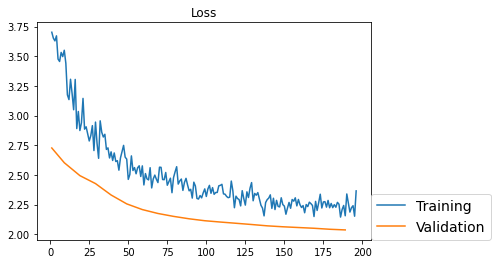

In [ ]:
# Re-initialize weights
reset_parameters(model)

# Train with defaul settings.
train_loss_history = fit(model)

**Note:** The validation loss (on the unseen data) is overall *lower* than the training loss. This might initially seem like an unexpected behaviour, but it results from the fact that we use 50% Dropout during training, meaning that half of the weights of the fully connected layers are not used during training. When evaluating the model on the validation set, Dropout is disabled, and all weights are used. This leads to a better prediction (i.e., a lower loss) on the validation set.

### 3.7 Performing quick experiments on reduced dataset
When searching for hyperparameters it is often useful to perform quick experiments on only a small subset of the data. You can do this by decreasing the batch size and setting `batches_per_epoch` to say 20. The effective size of the training set is then `bs*batches_per_epoch` (say `128*20 = 2,560`), and the total number of batches being processed during training is `bs*batches_per_epoch*epochs` (say `128*20*5 = 51200`).


Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 3.174669 val loss 2.5790153 val accuracy 0.0921875
t 20 lr 0.001 train loss 2.6774724 val loss 2.4438083 val accuracy 0.11875
t 30 lr 0.001 train loss 2.6579194 val loss 2.375291 val accuracy 0.1421875
t 40 lr 0.001 train loss 2.6472092 val loss 2.3169656 val accuracy 0.1671875
t 50 lr 0.001 train loss 2.3915837 val loss 2.2716541 val accuracy 0.171875
t 60 lr 0.001 train loss 2.4793646 val loss 2.2359276 val accuracy 0.1859375
t 70 lr 0.001 train loss 2.3632843 val loss 2.206747 val accuracy 0.1890625
t 80 lr 0.001 train loss 2.327141 val loss 2.1798873 val accuracy 0.2109375
t 90 lr 0.001 train loss 2.3221164 val loss 2.1609292 val accuracy 0.225
t 100 lr 0.001 train loss 2.3536656 val loss 2.1421013 val accuracy 0.2375


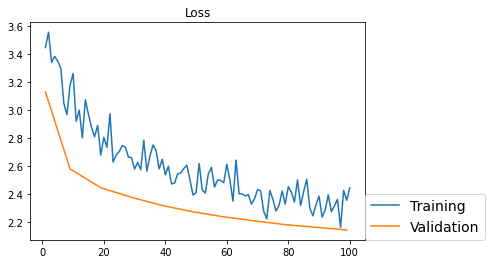

In [ ]:
# Re-initialize weights
reset_parameters(model)

# Example: Train on small subset
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

### 3.7 Train with custom optimizer
Fell free to experiment with these optimizers.

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.1 train loss 2.2224133 val loss 2.2308145 val accuracy 0.2234375
t 20 lr 0.1 train loss 2.126129 val loss 2.099184 val accuracy 0.1953125
t 30 lr 0.1 train loss 2.0265677 val loss 2.016146 val accuracy 0.2625
t 40 lr 0.1 train loss 1.9534667 val loss 1.9688154 val accuracy 0.2734375
t 50 lr 0.1 train loss 1.8174523 val loss 1.9481122 val accuracy 0.2640625
t 60 lr 0.1 train loss 2.0058813 val loss 1.8898138 val accuracy 0.29375
t 70 lr 0.1 train loss 1.8144728 val loss 1.8504267 val accuracy 0.2984375
t 80 lr 0.1 train loss 1.940455 val loss 1.8402373 val accuracy 0.3390625
t 90 lr 0.1 train loss 1.8078756 val loss 1.8336494 val accuracy 0.2984375
t 100 lr 0.1 train loss 1.8768318 val loss 1.7888104 val accuracy 0.3296875


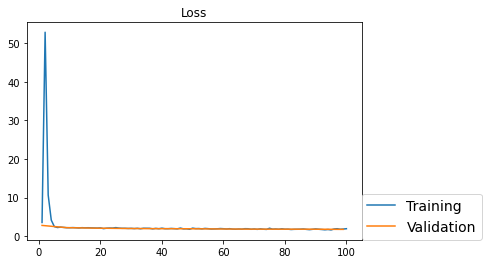

In [ ]:
#SGD + Momentum
def momentum_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Adagrad
def adagrad_optimizer(model):
  return optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0.0, weight_decay=0.0, initial_accumulator_value=0)

# RMSProp
def rmsprop_optimizer(model):
  return optim.RMSprop(model.parameters(), lr=0.1, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

# Adam
def adam_optimizer(model):
  return optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Train with custom optimizer (on small subset)
reset_parameters(model) # Reset network weights
train_loss_history = fit(model,opt_func=adagrad_optimizer,bs=128,epochs=5,batches_per_epoch=20)

## 4. Tasks: You are free to choose any of the tasks below
The overall goal is to make the model perform as good as possible on the CIFAR 10 dataset. Solving the tasks below might help you, but feel free to try other options. For inspiration, here is a list of other things, you could do:

- **Increase the capacity of the network** (add more conv layers, add more kernels in each layer, add another fully connected layer, add more connections in the fully connected layer, etc.)
- **Experiment with weight decay** (weight decay is an option for, say, the [SGD optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD))

General recommendations for hyperparameter search:
- Stage your search from course to fine
- Start with a small sample (subset) of the dataset to tune in on hyperparameters such as learning rate, and start with 1 epoch or less
- The second stage could then perform a narrower search with more data and/or more epochs
- Search for learning rates in powers of 10. Good learning rates to try: 1e-1, 1e-2, 1e-3, 1e-4, etc.)
- **Look at loss curves!!!**


### 4.1 Implement a learning rate scheduler
**Your task** is to replace the function `base_lr_scheduler` with your own `step_decay` function (or another type of learning rate scheduler if you prefer). In step decay the lerning rate is updated for every `step` batches according to the rule `lr = lr * decay_rate`. The input `t` is the current batch index, ranging from 1 to `T`, where `T = batches_per_epoch * epochs` is the total number of batches.

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 3.1298215 val loss 2.5452683 val accuracy 0.1015625
t 20 lr 0.0009000000000000001 train loss 3.0927641 val loss 2.4890776 val accuracy 0.0953125
t 30 lr 0.0008100000000000001 train loss 2.8436477 val loss 2.4643087 val accuracy 0.11875
t 40 lr 0.000729 train loss 2.7132874 val loss 2.4022167 val accuracy 0.1296875
t 50 lr 0.0006561000000000001 train loss 2.7531195 val loss 2.3563502 val accuracy 0.1390625
t 60 lr 0.00059049 train loss 2.8592365 val loss 2.324768 val accuracy 0.146875
t 70 lr 0.000531441 train loss 2.5450017 val loss 2.3019664 val accuracy 0.165625
t 80 lr 0.0004782969 train loss 2.5747392 val loss 2.285436 val accuracy 0.171875
t 90 lr 0.00043046721 train loss 2.501331 val loss 2.2725234 val accuracy 0.1765625
t 100 lr 0.000387420489 train loss 2.526909 val loss 2.259997 val accuracy 0.184375


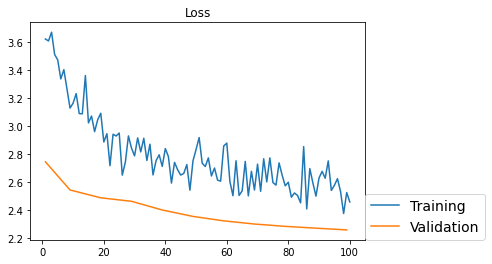

In [ ]:
def step_decay(t,T,lr,step=10,decay_rate=0.9):
  if t % step == 0:
    lr = lr * decay_rate
  return lr


# Train
model = Net()
reset_parameters(model)
train_loss_history = fit(model,lr_scheduler=step_decay,bs=128,epochs=5,batches_per_epoch=20)


**Sub-tasks:**
- What new hyperparameters are added with learning rate decay?
- See if you can make the model perform better with learning rate decay.

-Two more hyperparameters are added: step and decay_rate

### 4.2 Implement a learning rate finder
Finding a good initial learning rate can be done efficiently with a learning rate finder. Here is the basic idea:

You can modify the learning rate scheduler `base_lr_scheduler` to use a hardcoded list of learning rates. This can be used to implement a learning rate finder according to this principle:
- Start training and increase learning rate linearly after each batch (!!!), and calculate the loss
- Then display the loss as a function of learning rate.
- By manual inspection, select a suitable range of learning rates by locating the strongest downward slope.

Say the hardcoded learning rates are:

In [ ]:
# Ordered list of learning rates (ascending order)
lr_list = [0.001,0.01,0.05,0.1]

Then simply implement a learning rate scheduler that returns the t´th entry of the learning rate list:

In [ ]:
def lr_finder(t,T,lr):
  lr = lr_list[t-1]
  return lr

Note, the learning rate scheduler must have this interface: `(t,T,lr)`

Then train the model for as many batches as there are entries in the learning rate list:

In [ ]:
# Make sure that we process as many batches as there are learning rates in our list:
batches_per_epoch = len(lr_list)
epochs = 1

# Train
model = Net().to(device)
reset_parameters(model)
train_loss_history = fit(model,lr_scheduler=lr_finder,epochs=epochs,batches_per_epoch=batches_per_epoch,show_summary=False)

Epochs: 1 Batches per epoch: 4 Total number of batches 4


Plot the loss versus learning rate and inspect:

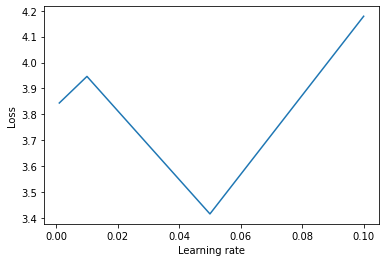

In [ ]:
plt.figure()
plt.plot(lr_list,train_loss_history)
plt.xlabel('Learning rate');
plt.ylabel('Loss');
plt.show()

**Your task** is to implement a learning rate finder that searches through a range of learning rates, like above.

The range of learning rates should be logarithmic (say from 10^-6 to 10^1). You can define the list of learning rates using `np.logspace`.

Then plot the loss versus the learning rate. It is a good idea to use a logarithmic scale on the x-axis (see `plt.xscale('log')`).

[1.00000000e-06 1.32571137e-06 1.75751062e-06 2.32995181e-06
 3.08884360e-06 4.09491506e-06 5.42867544e-06 7.19685673e-06
 9.54095476e-06 1.26485522e-05 1.67683294e-05 2.22299648e-05
 2.94705170e-05 3.90693994e-05 5.17947468e-05 6.86648845e-05
 9.10298178e-05 1.20679264e-04 1.59985872e-04 2.12095089e-04
 2.81176870e-04 3.72759372e-04 4.94171336e-04 6.55128557e-04
 8.68511374e-04 1.15139540e-03 1.52641797e-03 2.02358965e-03
 2.68269580e-03 3.55648031e-03 4.71486636e-03 6.25055193e-03
 8.28642773e-03 1.09854114e-02 1.45634848e-02 1.93069773e-02
 2.55954792e-02 3.39322177e-02 4.49843267e-02 5.96362332e-02
 7.90604321e-02 1.04811313e-01 1.38949549e-01 1.84206997e-01
 2.44205309e-01 3.23745754e-01 4.29193426e-01 5.68986603e-01
 7.54312006e-01 1.00000000e+00]
Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 9.540954763499944e-06 train loss 3.8242567 val loss 2.8482084 val accuracy 0.097055286
t 20 lr 0.00015998587196060574 train loss 3.859276 val loss 2.9272883 val accuracy

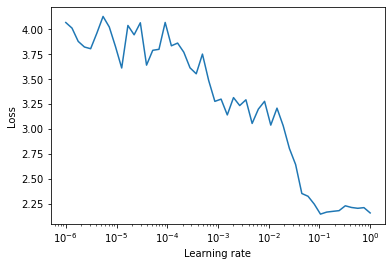

In [ ]:
batches_per_epoch = 50
lr_list = np.logspace(-6,0,batches_per_epoch) # Your code goes here
print(lr_list)

# Run
model = Net().to(device)
reset_parameters(model)
train_loss_history = fit(model,lr_scheduler=lr_finder,epochs=epochs,batches_per_epoch=batches_per_epoch,show_summary=False)
plt.figure()
plt.plot(lr_list,train_loss_history)
plt.xscale('log') # Use log scale on x-axis
plt.xlabel('Learning rate');
plt.ylabel('Loss');

**Comments: What to look for?**
The numerical value of the loss is not important. What is important is the rate of change of the loss. So what we are looking for as a range of learning rates, where the loss decreases most rapidly. That seems to be somewhere between 10^-2 and 10^-1 (look for steepest slope).

#### 4.2.2 Solution
Train 4 cycles, and in each cycle use 50 learning rates from 10^-2 to 10^-1.

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 2.033081 val loss 2.1692255 val accuracy 0.23317307
t 20 lr 0.04291934260128778 train loss 1.9832658 val loss 1.9232367 val accuracy 0.29777643
t 30 lr 0.02682695795279726 train loss 1.8366599 val loss 1.826892 val accuracy 0.35036057
t 40 lr 0.016768329368110083 train loss 1.7743952 val loss 1.738934 val accuracy 0.37560096
t 50 lr 0.010481131341546858 train loss 1.6871457 val loss 1.7055961 val accuracy 0.3891226


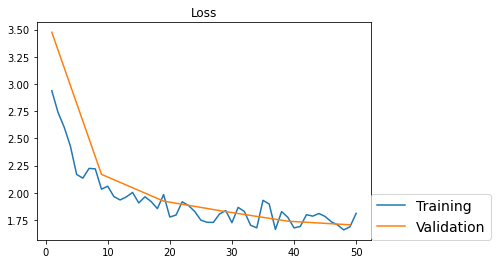

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.6730198 val loss 1.6778703 val accuracy 0.39032453
t 20 lr 0.04291934260128778 train loss 1.6515954 val loss 1.6357424 val accuracy 0.40655047
t 30 lr 0.02682695795279726 train loss 1.642655 val loss 1.6368675 val accuracy 0.41105768
t 40 lr 0.016768329368110083 train loss 1.5804687 val loss 1.5756252 val accuracy 0.42758414
t 50 lr 0.010481131341546858 train loss 1.6509901 val loss 1.5729523 val accuracy 0.4329928


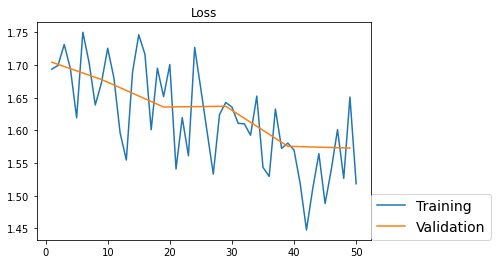

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.5378903 val loss 1.5814846 val accuracy 0.43058893
t 20 lr 0.04291934260128778 train loss 1.5275619 val loss 1.5326614 val accuracy 0.43810096
t 30 lr 0.02682695795279726 train loss 1.5106928 val loss 1.5827768 val accuracy 0.4236779
t 40 lr 0.016768329368110083 train loss 1.4395463 val loss 1.4861227 val accuracy 0.45673078
t 50 lr 0.010481131341546858 train loss 1.5030175 val loss 1.4678917 val accuracy 0.4783654


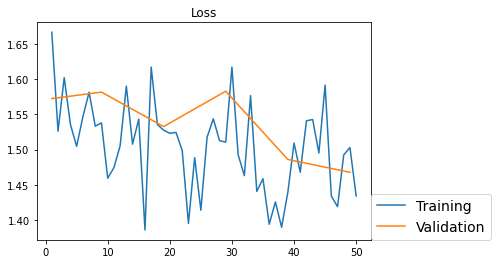

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.5167822 val loss 1.512392 val accuracy 0.45432693
t 20 lr 0.04291934260128778 train loss 1.4262047 val loss 1.4936906 val accuracy 0.46604568
t 30 lr 0.02682695795279726 train loss 1.5080084 val loss 1.4634902 val accuracy 0.46304086
t 40 lr 0.016768329368110083 train loss 1.3169405 val loss 1.4553136 val accuracy 0.4858774
t 50 lr 0.010481131341546858 train loss 1.296941 val loss 1.4187961 val accuracy 0.49278846


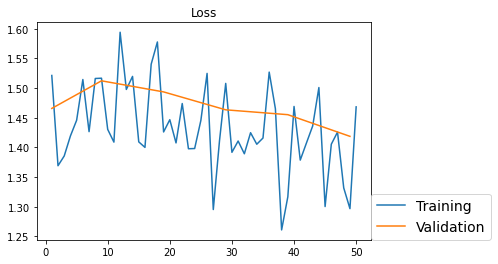

Epochs: 1 Batches per epoch: 50 Total number of batches 50
t 10 lr 0.06866488450042998 train loss 1.3717397 val loss 1.5914251 val accuracy 0.43870193
t 20 lr 0.04291934260128778 train loss 1.4704789 val loss 1.5173091 val accuracy 0.4609375
t 30 lr 0.02682695795279726 train loss 1.3341887 val loss 1.4259497 val accuracy 0.4936899
t 40 lr 0.016768329368110083 train loss 1.281703 val loss 1.4241537 val accuracy 0.5
t 50 lr 0.010481131341546858 train loss 1.3060025 val loss 1.404648 val accuracy 0.49158654


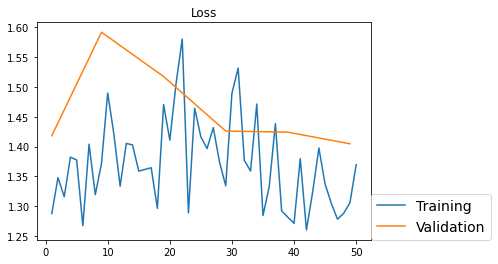

In [ ]:
lr_list = np.logspace(-2,-1,50) # Learning rates in ascending order
lr_list = np.flip(lr_list,axis=0) # Learning rates in descending order
batches_per_epoch = len(lr_list)
epochs = 1

def CLR(t,T,lr):
  return lr_list[t-1]

reset_parameters(model)
for cycle in range(5):
  train_loss_history = fit(model,lr_scheduler=CLR,epochs=epochs,batches_per_epoch=batches_per_epoch)

### 4.3 Experiment with dropout
Below is a slight modification of our model that allows changing the dropout fraction (p).

**Your task** is to experiment with different values of p.

- What does setting p = 0 mean?
- Try different values of p (say 0, 0.1, 0.5 and 0.9). What is the optimal value of p?

In [ ]:
def Net(p=0.5):
  net = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
      nn.BatchNorm2d(num_features=6),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
      nn.BatchNorm2d(num_features=16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      Lambda(lambda x: x.view(x.size(0), -1)), # Vectorize
      nn.Dropout(p=p),
      nn.Linear(in_features=16*5*5,out_features=120),
      nn.ReLU(),
      nn.Linear(in_features=120, out_features=10)
  )
  return net

# Model with p=0.25
model = Net(p=0.25).to(device)

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 2.7325265 val loss 2.4517326 val accuracy 0.103125
t 20 lr 0.001 train loss 2.4600523 val loss 2.3475668 val accuracy 0.1359375
t 30 lr 0.001 train loss 2.2129304 val loss 2.285127 val accuracy 0.1578125
t 40 lr 0.001 train loss 2.193115 val loss 2.2255569 val accuracy 0.1890625
t 50 lr 0.001 train loss 2.10394 val loss 2.1801257 val accuracy 0.190625
t 60 lr 0.001 train loss 2.1207747 val loss 2.141192 val accuracy 0.2125
t 70 lr 0.001 train loss 2.011649 val loss 2.1065812 val accuracy 0.2296875
t 80 lr 0.001 train loss 1.9729924 val loss 2.0688128 val accuracy 0.2453125
t 90 lr 0.001 train loss 1.962067 val loss 2.0318367 val accuracy 0.2640625
t 100 lr 0.001 train loss 2.0122042 val loss 2.0123534 val accuracy 0.2515625


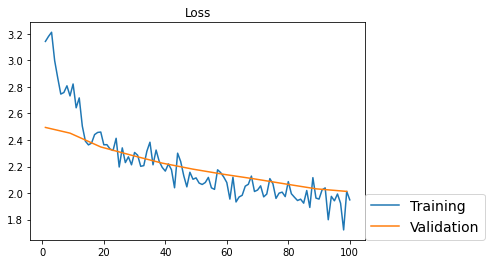

In [ ]:
# p = 0 means no dropout
model = Net(p=0.0).to(device)
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 6.359543 val loss 2.6036067 val accuracy 0.0890625
t 20 lr 0.001 train loss 5.287879 val loss 2.5389621 val accuracy 0.1015625
t 30 lr 0.001 train loss 4.438541 val loss 2.512462 val accuracy 0.0921875
t 40 lr 0.001 train loss 3.9296026 val loss 2.3744311 val accuracy 0.1046875
t 50 lr 0.001 train loss 3.6095119 val loss 2.2484508 val accuracy 0.1390625
t 60 lr 0.001 train loss 3.6788554 val loss 2.1991768 val accuracy 0.1765625
t 70 lr 0.001 train loss 3.2661276 val loss 2.181596 val accuracy 0.1828125
t 80 lr 0.001 train loss 3.2635577 val loss 2.1692119 val accuracy 0.1890625
t 90 lr 0.001 train loss 3.0363927 val loss 2.1548216 val accuracy 0.209375
t 100 lr 0.001 train loss 2.9350257 val loss 2.143869 val accuracy 0.2109375


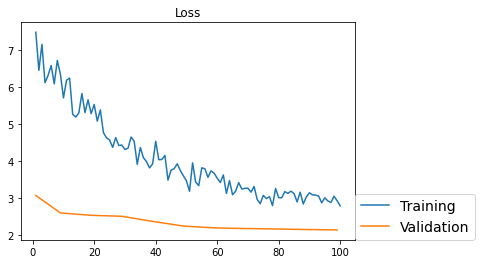

In [ ]:
# p = 0.9 means "heavy dropout", which is in general a bad idea
model = Net(p=0.9).to(device)
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 2.6244364 val loss 2.509948 val accuracy 0.103125
t 20 lr 0.001 train loss 2.5688236 val loss 2.3952363 val accuracy 0.1359375
t 30 lr 0.001 train loss 2.5030673 val loss 2.326208 val accuracy 0.15625
t 40 lr 0.001 train loss 2.3677158 val loss 2.2547424 val accuracy 0.1796875
t 50 lr 0.001 train loss 2.1994982 val loss 2.1957011 val accuracy 0.2234375
t 60 lr 0.001 train loss 2.159203 val loss 2.1603968 val accuracy 0.2140625
t 70 lr 0.001 train loss 2.2265844 val loss 2.1280074 val accuracy 0.228125
t 80 lr 0.001 train loss 2.0572119 val loss 2.102019 val accuracy 0.2421875
t 90 lr 0.001 train loss 2.0635478 val loss 2.0805871 val accuracy 0.25
t 100 lr 0.001 train loss 2.0290315 val loss 2.0620463 val accuracy 0.2625


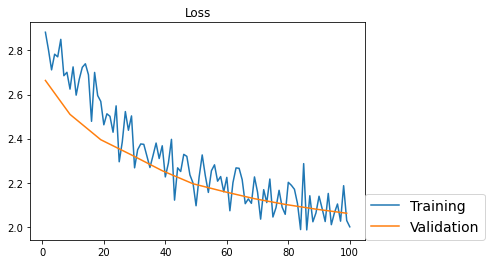

In [ ]:
# p = 0.1
model = Net(p=0.1).to(device)
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)

### 4.4 Data augmentation
Adding more training data is the best way to improve your models abiliy to generalize to unseen data. Data augmentations is basically about generating additional *fake data" to expand the size of your training set.

**Your task** is to experiment with different types of data augmentation. All you have to do is change the transformer below and add some of the available transforms: https://pytorch.org/docs/stable/torchvision/transforms.html

You can find inspiration in Lab 4: https://github.com/aivclab/dlcourse/blob/master/Lab_4_(part3)_PyTorch_Transfer_Learning.ipynb


Files already downloaded and verified
Files already downloaded and verified
images.shape torch.Size([64, 3, 32, 32])


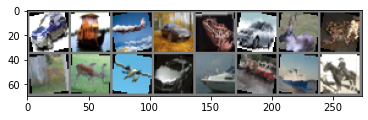

  car  ship plane   car  frog   car  deer  frog  deer  deer plane   car  ship truck  ship horse


In [ ]:
mean = 0.5
std = 0.5
transform = transforms.Compose(
    [ # My solution
      transforms.RandomHorizontalFlip(0.5), # Horizontally flip the given PIL Image randomly with a given probability.
      transforms.ColorJitter(brightness=0.1), # Randomly change the brightness, contrast and saturation of an image
      transforms.RandomRotation(degrees=15), # Rotate the image by angle.
      transforms.ToTensor(),
      transforms.Normalize((mean, mean, mean), (std, std, std))
     ])

# Batch size
bs = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=2,drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=2,drop_last=True)

# Get a batch of some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print('images.shape',images.shape)

# show 10 images and print labels
imshow(torchvision.utils.make_grid(images[0:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

Epochs: 5 Batches per epoch: 20 Total number of batches 100
t 10 lr 0.001 train loss 3.1853771 val loss 2.4766607 val accuracy 0.1109375
t 20 lr 0.001 train loss 3.09971 val loss 2.496595 val accuracy 0.1234375
t 30 lr 0.001 train loss 2.831167 val loss 2.379545 val accuracy 0.159375
t 40 lr 0.001 train loss 2.6035929 val loss 2.2999945 val accuracy 0.178125
t 50 lr 0.001 train loss 2.645378 val loss 2.2019477 val accuracy 0.2046875
t 60 lr 0.001 train loss 2.5898438 val loss 2.16742 val accuracy 0.23125
t 70 lr 0.001 train loss 2.330725 val loss 2.1350522 val accuracy 0.2484375
t 80 lr 0.001 train loss 2.461837 val loss 2.122529 val accuracy 0.2296875
t 90 lr 0.001 train loss 2.4806328 val loss 2.1203752 val accuracy 0.265625
t 100 lr 0.001 train loss 2.4600418 val loss 2.0583632 val accuracy 0.24375


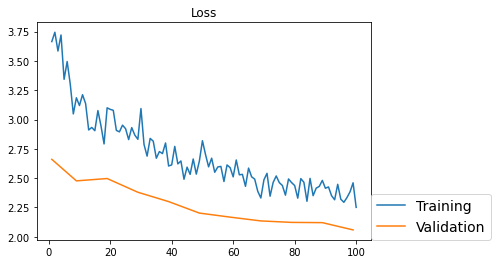

In [ ]:
# Train
model = Net().to(device)
reset_parameters(model)
train_loss_history = fit(model,bs=128,epochs=5,batches_per_epoch=20)